In [1]:
import numpy as np
from ase import Atoms
from ase.calculators.vasp import Vasp  # Example calculator, replace with the actual calculator you use
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from ase.io import read
from phonopy.units import VaspToTHz
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
from ase.dft.kpoints import  get_special_points
import os
import matplotlib.pyplot as plt
from ase.io.lammpsdata import write_lammps_data

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.style.use('shera')

In [4]:
atoms = read('/work/scratch/as41vomu/PhD/pyiron_projects/GBs/relax/cubic_relax_hdf5/cubic_relax/dump.out', index=-1)
atoms

Atoms(symbols='HLiHe3', pbc=True, cell=[[4.038889926267809, 0.0, 0.0], [3.1990838886715635e-11, 4.038889926267808, 0.0], [3.573559477622879e-17, 1.506122862669131e-17, 4.038889926267809]], momenta=..., calculator=SinglePointCalculator(...))

In [5]:
# H --> Ba , He --> O and , Li --> Ti
for atom in atoms:
    if atom.symbol == 'H':
        atom.symbol = 'Ba'
    if atom.symbol == 'He':
        atom.symbol = 'O'
    if atom.symbol == 'Li':
        atom.symbol = 'Ti'

In [6]:
atoms


Atoms(symbols='BaTiO3', pbc=True, cell=[[4.038889926267809, 0.0, 0.0], [3.1990838886715635e-11, 4.038889926267808, 0.0], [3.573559477622879e-17, 1.506122862669131e-17, 4.038889926267809]], momenta=..., calculator=SinglePointCalculator(...))

In [8]:
atoms.cell.cellpar()

array([ 4.03888993,  4.03888993,  4.03888993, 90.        , 90.        ,
       90.        ])

In [9]:
class PhononCalculation:
    def __init__(self, atoms: Atoms, supercell_matrix: list, displacement_distance: float, calc_type= 'vasp'):
        self.atoms = atoms
        self.supercell_matrix = supercell_matrix
        self.displacement_distance = displacement_distance
        self.phonon = None
        self.supercells = None
        self.fc = False
        self.mesh = False
        self.calc_type = calc_type

    def ase_to_phonopy(self):
        phonopy_atoms = PhonopyAtoms(symbols=self.atoms.get_chemical_symbols(),
                                     scaled_positions=self.atoms.get_scaled_positions(),
                                     cell=self.atoms.get_cell())
        return phonopy_atoms

    def phonopy_to_ase(self, phonopy_atoms):
        ase_atoms = Atoms(symbols=phonopy_atoms.get_chemical_symbols(),
                          positions=phonopy_atoms.get_positions(),
                          cell=phonopy_atoms.get_cell(),
                          pbc=True)
        return ase_atoms
    
    def setup_phonon(self, calculator=None):
        if self.calc_type == 'vasp':
            self.setup_phonon_vasp(calculator)
        elif self.calc_type == 'lammps':
            self.setup_phonon_lammps()
        else:
            raise ValueError('Unsupported calculator type. Supported types: "vasp", "lammps".')

    def setup_phonon_vasp(self, calculator):
        phonopy_atoms = self.ase_to_phonopy()
        self.phonon = Phonopy(phonopy_atoms, supercell_matrix=self.supercell_matrix, factor=VaspToTHz)
        self.phonon.generate_displacements(distance=self.displacement_distance)
        self.supercells = self.phonon.supercells_with_displacements

        for i, su in enumerate(self.supercells):
            ase_atoms = self.phonopy_to_ase(su)
            if calculator is None:
                raise ValueError('Calculator not provided')
            ase_atoms.set_calculator(calculator)
            directory = f'./displacement-{i}'
            os.makedirs(directory, exist_ok=True)
            calculator.set(directory=directory)
            calculator.write_input(ase_atoms)
        
        self.phonon.save("phonopy_disp.yaml")

    def setup_phonon_lammps(self):
        phonopy_atoms = self.ase_to_phonopy()
        self.phonon = Phonopy(phonopy_atoms, supercell_matrix=self.supercell_matrix, factor=VaspToTHz)
        self.phonon.generate_displacements(distance=self.displacement_distance)
        self.supercells = self.phonon.supercells_with_displacements
        self.phonon.save("phonopy_disp.yaml")

        for i, su in enumerate(self.supercells):
            ase_atoms = self.phonopy_to_ase(su)
            directory = f'./displacement-{i}'
            os.makedirs(directory, exist_ok=True)
            write_lammps_data(f'{directory}/data.lammps', ase_atoms, specorder=['Ba', 'O', 'Ti'], atom_style='atomic')

                
    def calculate_fc(self):
        if self.calc_type == 'vasp':
            self.calculate_fc_vasp()
        elif self.calc_type == 'lammps':
            self.calculate_fc_lammps()
        else:
            raise ValueError('Unsupported calculator type. Supported types: "vasp", "lammps".')

    def calculate_fc_vasp(self):
        sets_of_forces = []
        for i, su in enumerate(self.supercells):
            directory = f'./displacement-{i}'
            if os.path.exists(f'{directory}/OUTCAR'):
                atoms = read(f'{directory}/OUTCAR', format='vasp-out')
                forces = atoms.get_forces()
                sets_of_forces.append(forces)
            else:
                raise FileNotFoundError(f'OUTCAR file does not exist in {directory}')

        self.phonon.forces = sets_of_forces
        self.phonon.produce_force_constants()
        self.phonon.save(settings={'force_constants': True})
        self.force_constants_calculated = True
            
    def calculate_fc_lammps(self):
        sets_of_forces = []
        for i, su in enumerate(self.supercells):
            directory = f'./displacement-{i}'
            if os.path.exists(f'{directory}/dump.out'):
                atoms = read(f'{directory}/dump.out', format='lammps-dump-text', index=-1)
                forces = atoms.get_forces()
                sets_of_forces.append(forces)
            else:
                raise FileNotFoundError(f'lmp.dump file does not exist in {directory}')

        self.phonon.forces = sets_of_forces
        self.phonon.produce_force_constants()
        self.phonon.save(settings={'force_constants': True})
        self.force_constants_calculated = True

        
    def _run_mesh(self, mesh=[20,20,20]):
        self.phonon.run_mesh( with_eigenvectors=True, is_mesh_symmetry=False)
        mesh_dict = self.phonon.get_mesh_dict()
        qpoints = mesh_dict['qpoints']
        weights = mesh_dict['weights']
        frequencies = mesh_dict['frequencies']
        eigenvectors = mesh_dict['eigenvectors']
        # best way to save it in single file
        # check if a folder exists with name mesh_data if not create one
        if not os.path.exists('mesh_data'):
            os.makedirs('mesh_data')
        np.save('mesh_data/qpoints.npy', qpoints)
        np.save('mesh_data/weights.npy', weights)
        np.save('mesh_data/frequencies.npy', frequencies)
        np.save('mesh_data/eigenvectors.npy', eigenvectors)
        self.mesh = True
        
    def phonon_dos(self):
        if not self.fc:
            self.calculte_fc()
        if not self.mesh:
            self._run_mesh()
        self.phonon.run_total_dos()
        self.phonon.run_projected_dos()
        total_dos_dict = self.phonon.get_total_dos_dict()
        projected_dos_dict = self.phonon.get_projected_dos_dict()
        frequencies_tot, total_dos = total_dos_dict['frequencies'], total_dos_dict['total_dos']
        frequencies_proj, projected_dos = projected_dos_dict['frequencies'], projected_dos_dict['projected_dos']

        if not os.path.exists('dos_data'):
            os.makedirs('dos_data')
        np.save('dos_data/frequencies_tot.npy', frequencies_tot)
        np.save('dos_data/total_dos.npy', total_dos)
        np.save('dos_data/frequencies_proj.npy', frequencies_proj)
        np.save('dos_data/projected_dos.npy', projected_dos)
    
    def phonon_band_structure(self, path_string=None):
        if not self.fc:
            self.calculate_fc()
        if not self.mesh:
            self._run_mesh()
            
        special_points = get_special_points(cell=atoms.get_cell())

        split_path = path_string.split(',')
        labels = []
        
        path = []

        # Loop through each segment in the path string
        for p in split_path:  
            tmp_list = []
            for point in p:
                labels.append(point)
                if point in special_points:
                    tmp_list.append(special_points[point].tolist())
            path.append(tmp_list)
        qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
        self.phonon.run_band_structure(qpoints, path_connections=connections, labels=labels)   
        self.phonon.write_yaml_band_structure(filename='band.yaml')     
        frequencies = self.phonon.get_band_structure_dict()['frequencies']
        qpoints = self.phonon.get_band_structure_dict()['qpoints']
        distances = self.phonon.get_band_structure_dict()['distances']
        eigenvectors = self.phonon.get_band_structure_dict()['eigenvectors']
        # make a phonon_data file and save everything there
        if not os.path.exists('phonon_data'):
            os.makedirs('phonon_data')
        np.save('phonon_data/frequencies.npy', frequencies)
        np.save('phonon_data/qpoints.npy', qpoints)
        np.save('phonon_data/distances.npy', distances)
        np.save('phonon_data/eigenvectors.npy', eigenvectors)
        np.save('phonon_data/labels.npy', labels)
        # self.phonon.auto_band_structure(plot=True).show()



In [10]:
atoms

Atoms(symbols='BaTiO3', pbc=True, cell=[[4.038889926267809, 0.0, 0.0], [3.1990838886715635e-11, 4.038889926267808, 0.0], [3.573559477622879e-17, 1.506122862669131e-17, 4.038889926267809]], momenta=..., calculator=SinglePointCalculator(...))

In [11]:
phc = PhononCalculation(atoms, supercell_matrix=[3,3,3], displacement_distance=0.1, calc_type='lammps')
phc.setup_phonon_lammps()

In [12]:
phc.phonon_band_structure(path_string='GXMGRX,RM')

In [13]:
frequencies = np.load('phonon_data/frequencies.npy', allow_pickle=True)
qpoints = np.load('phonon_data/qpoints.npy', allow_pickle=True)
distances = np.load('phonon_data/distances.npy', allow_pickle=True)
eigenvectors = np.load('phonon_data/eigenvectors.npy', allow_pickle=True)
labels = np.load('phonon_data/labels.npy', allow_pickle=True)
# coordinates = np.load('phonon_data/coordinates.npy', allow_pickle=True)

/tmp/ipykernel_576105/4119484235.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


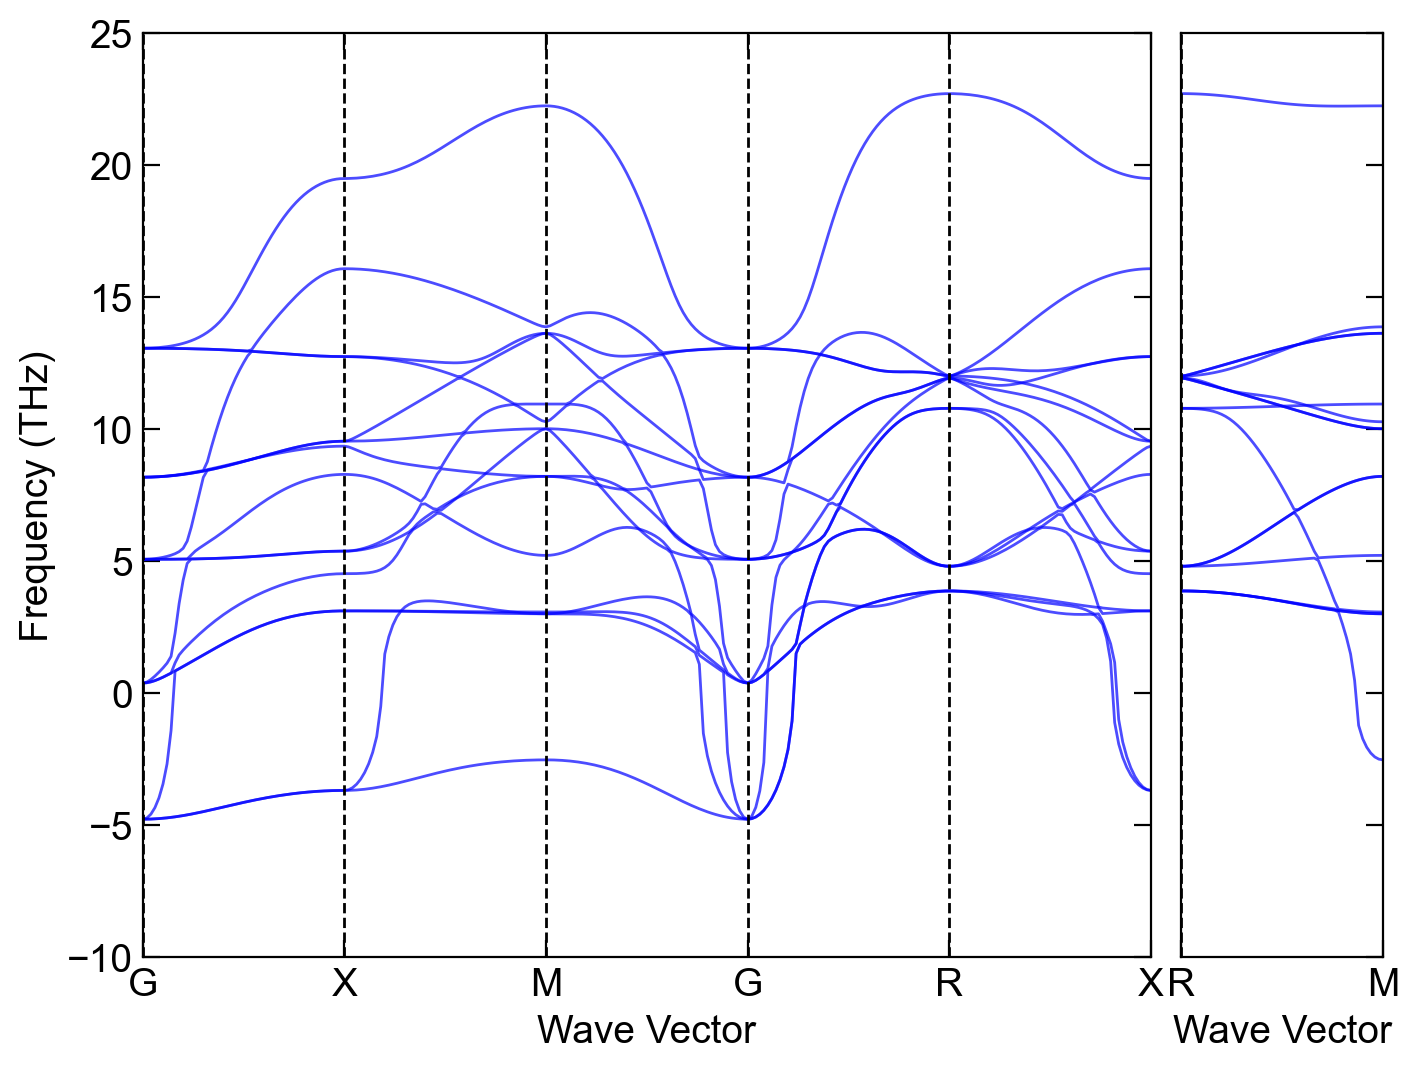

In [14]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def read_phonopy_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

def extract_band_data(phonon_data):
    all_frequencies = []
    for point in phonon_data['phonon']:
        frequencies = [band['frequency'] for band in point['band']]
        all_frequencies.append(frequencies)
    return np.array(all_frequencies)

def plot_band_structure(frequencies, path_string, segment_sizes):
    # Split the path string into two parts if there's a comma
    paths = path_string.split(',')
    labels = [list(path) for path in paths]
    
    # Calculate the width ratio based on the number of segments in each subplot
    width_ratio = [sum(segment_sizes[:len(labels[0])-1])]
    if len(paths) > 1:
        width_ratio.append(sum(segment_sizes[len(labels[0])-1:]))
    
    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, len(paths), width_ratios=width_ratio, wspace=0.05)
    
    axes = [plt.subplot(gs[0])]
    if len(paths) > 1:
        axes.append(plt.subplot(gs[1], sharey=axes[0]))
    
    total_points = sum(segment_sizes)
    points_per_segment = segment_sizes[0]  # Assuming all segments have the same number of points
    
    # Calculate x-coordinates for each segment
    x_coords = np.concatenate([np.linspace(i, i+1, points_per_segment) for i in range(len(segment_sizes))])
    
    # Split data for subplots
    split_index = sum(segment_sizes[:len(labels[0])-1])
    x_coords_split = np.split(x_coords, [split_index]) if len(paths) > 1 else [x_coords]
    freq_split = np.split(frequencies, [split_index]) if len(paths) > 1 else [frequencies]
    
    for ax, x_coord, freq, lab in zip(axes, x_coords_split, freq_split, labels):
        # Plot bands
        for band in range(frequencies.shape[1]):
            ax.plot(x_coord - x_coord.min(), freq[:, band], color='blue', linewidth=1, alpha=0.7)
        
        # Set labels and ticks
        ax.set_xticks(range(len(lab)))
        ax.set_xticklabels(lab)
        ax.set_xlim(0, len(lab) - 1)
        ax.set_ylim(-10, 25)  # Adjust the y-limit as needed
        
        # Add vertical lines at high symmetry points
        for i in range(len(lab)):
            ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
        
        # Set labels
        ax.set_xlabel('Wave Vector')
    
    # Remove y-axis ticks from the second subplot if it exists
    if len(axes) > 1:
        axes[1].yaxis.set_tick_params(left=False, labelleft=False)
    
    # Set y-label only for the first subplot
    axes[0].set_ylabel('Frequency (THz)')
    
    
    plt.tight_layout()
    plt.savefig('phonon_band_structure.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
file_path = 'band.yaml'  # Replace with your YAML file path
phonon_data = read_phonopy_yaml(file_path)
frequencies = extract_band_data(phonon_data)

path_string = 'GXMGRX,RM'  # This can be changed to any valid path
segment_sizes = phonon_data['segment_nqpoint']

plot_band_structure(frequencies, path_string, segment_sizes)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yaml

def read_phonopy_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

def extract_band_data(phonon_data):
    all_frequencies = []
    for point in phonon_data['phonon']:
        frequencies = [band['frequency'] for band in point['band']]
        all_frequencies.append(frequencies)
    return np.array(all_frequencies)

def plot_band_structure(frequencies1, frequencies2, path_string, segment_sizes):
    # Split the path string into two parts if there's a comma
    paths = path_string.split(',')
    labels = [list(path) for path in paths]
    
    # Calculate the width ratio based on the number of segments in each subplot
    width_ratio = [sum(segment_sizes[:len(labels[0])-1])]
    if len(paths) > 1:
        width_ratio.append(sum(segment_sizes[len(labels[0])-1:]))
    
    fig = plt.figure(figsize=(6,4))
    gs = gridspec.GridSpec(1, len(paths), width_ratios=width_ratio, wspace=0.05)
    
    axes = [plt.subplot(gs[0])]
    if len(paths) > 1:
        axes.append(plt.subplot(gs[1], sharey=axes[0]))
    
    total_points = sum(segment_sizes)
    points_per_segment = segment_sizes[0]  # Assuming all segments have the same number of points
    
    # Calculate x-coordinates for each segment
    x_coords = np.concatenate([np.linspace(i, i+1, points_per_segment) for i in range(len(segment_sizes))])
    
    # Split data for subplots
    split_index = sum(segment_sizes[:len(labels[0])-1])
    x_coords_split = np.split(x_coords, [split_index]) if len(paths) > 1 else [x_coords]
    freq1_split = np.split(frequencies1, [split_index]) if len(paths) > 1 else [frequencies1]
    freq2_split = np.split(frequencies2, [split_index]) if len(paths) > 1 else [frequencies2]
    
    for ax, x_coord, freq1, freq2, lab in zip(axes, x_coords_split, freq1_split, freq2_split, labels):
        # Plot bands for frequencies1
        for band in range(frequencies1.shape[1]):
            ax.plot(x_coord - x_coord.min(), freq1[:, band], color='blue', linewidth=1, alpha=0.7, label='ACE' if band == 0 else "")
        
        # Plot bands for frequencies2
        for band in range(frequencies2.shape[1]):
            ax.plot(x_coord - x_coord.min(), freq2[:, band], color='red', linewidth=1, alpha=0.7, label='DFT' if band == 0 else "")
        
        # Set labels and ticks
        ax.set_xticks(range(len(lab)))
        ax.set_xticklabels(lab)
        ax.set_xlim(0, len(lab) - 1)
        ax.set_ylim(-10, 25)  # Adjust the y-limit as needed
        
        # Add vertical lines at high symmetry points
        for i in range(len(lab)):
            ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
        
        # Set labels
        ax.set_xlabel('Wave Vector')
    
    # Remove y-axis ticks from the second subplot if it exists
    if len(axes) > 1:
        axes[1].yaxis.set_tick_params(left=False, labelleft=False)
    
    # Set y-label only for the first subplot
    axes[0].set_ylabel('Frequency (THz)')
    
    # Add legend
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.savefig('phonon_band_structure_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()



/tmp/ipykernel_576105/873227555.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


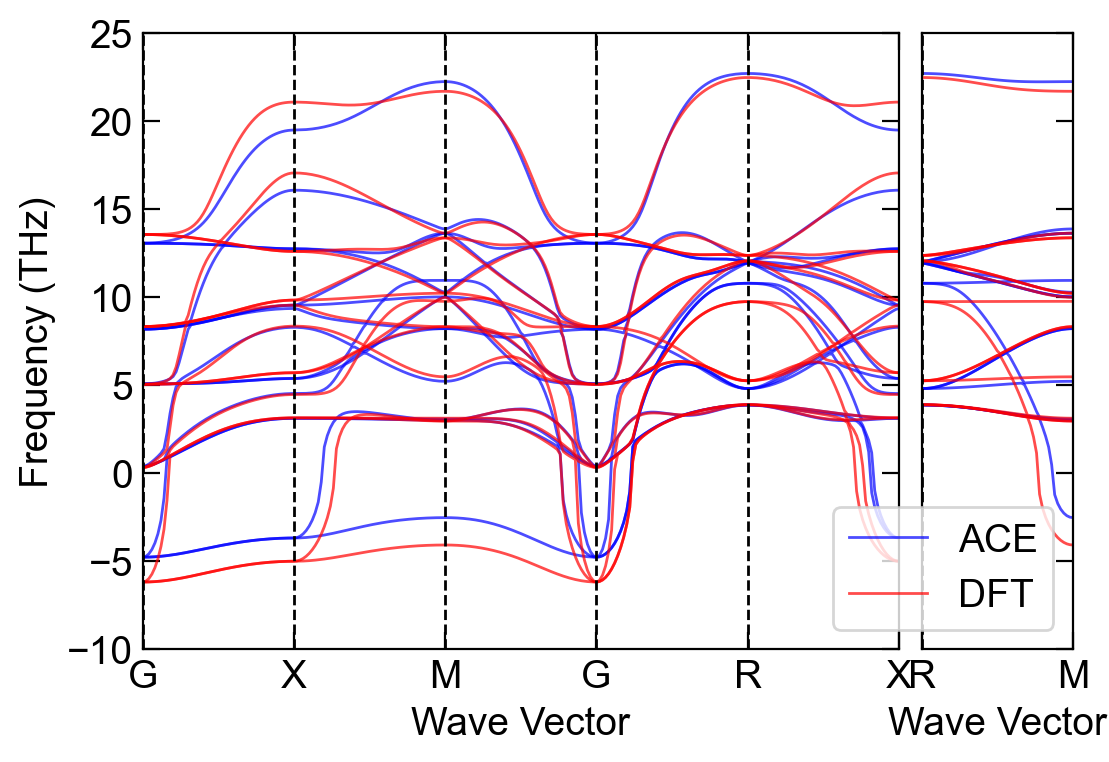

In [28]:
# Main execution
file_path1 = './band.yaml'  # Replace with your first YAML file path
file_path2 = '../../ase_phonop_calc/mp-2998/band.yaml'  # Replace with your second YAML file path

phonon_data1 = read_phonopy_yaml(file_path1)
phonon_data2 = read_phonopy_yaml(file_path2)

frequencies1 = extract_band_data(phonon_data1)
frequencies2 = extract_band_data(phonon_data2)

path_string = 'GXMGRX,RM'  # This can be changed to any valid path
segment_sizes = phonon_data1['segment_nqpoint']  # Assuming both datasets have the same segment sizes

plot_band_structure(frequencies1, frequencies2, path_string, segment_sizes)